In [1]:
## OCFE with Butcher Coefficients of Gauss-Legendre
import numpy as np
#from scipy.special import roots_sh_legendre
from scipy.optimize import root

In [2]:
# Gauss-Legendre collocation coefficients (A, b, c) on [0,1]
def gauss_legendre_collocation_coeffs(p):
    # c in (0,1), w are Gauss-Legendre quadrature weights (not used directly here)
    # x, _ = roots_legendre(p)          # nodes in (-1,1)
    # c = 0.5 * (x + 1.0)               # map to (0,1)

    from scipy.special import roots_sh_legendre
    c, _ = roots_sh_legendre(p)

    # Build Vandermonde V_{k,m} = c_k^m, m=0..p-1, k=0..p-1
    V = np.vander(c, N=p, increasing=True)    # shape (p, p)

    # Coefficients of Lagrange polynomials l_j(s) in power basis:
    # Solve V * C^T = I  ->  C^T = V^{-1}  ->  C = (V^{-1})^T
    Vinv = np.linalg.inv(V)
    C = Vinv.T                                # C[j, m] are coeffs of l_j(s) = sum_m C[j,m]*s^m

    # A_ij = ∫_0^{c_i} l_j(s) ds = sum_m C[j,m] * c_i^{m+1} / (m+1)
    m_idx = np.arange(1, p+1)                 # powers m+1
    c_pows = c[:, None] ** m_idx[None, :]     # shape (p, p) with c_i^{m+1}
    A = c_pows @ (C / m_idx).T                # (p,p)

    # b_j = ∫_0^1 l_j(s) ds = sum_m C[j,m] / (m+1)
    b = (C / m_idx).sum(axis=1)               # (p,)

    return A, b, c    

In [3]:
# One finite element solve using Gauss collocation (Legendre nodes only)
def solve_element_gauss(f, t_left, h, z_left, p, args=()):
    z_left = np.asarray(z_left, float)
    n = z_left.size

    A, b, c = gauss_legendre_collocation_coeffs(p)

    # Pack/unpack helpers for Newton unknown vector [Y_1; ...; Y_p]
    def pack(Y):   # Y: (p, n)
        return Y.reshape(p * n)

    def unpack(vec):  # vec: (p*n,)
        return vec.reshape(p, n)

    # Initial guess: forward-Euler predictor at each stage time
    Y0 = np.tile(z_left, (p, 1))
    U0 = pack(Y0)

    # Residual for stages: R_i = Y_i - z_left - h * sum_j A_ij f(Y_j, t_left + c_j h)
    def residual(U):
        Y = unpack(U)                           # (p, n)
        F = np.zeros_like(Y)                    # f(Y_j, t_j)
        for j in range(p):
            tj = t_left + c[j] * h
            F[j, :] = np.asarray(f(Y[j, :], tj, *args), float)
        R = Y - (z_left[None, :] + h * (A @ F))
        return R.ravel()

    sol = root(residual, U0, method="hybr")
    if not sol.success:
        raise RuntimeError(f"Gauss collocation stage solve failed at t={t_left}: {sol.message}")

    Y = unpack(sol.x)                            # (p, n)

    # Right endpoint via quadrature
    F_end = np.zeros_like(Y)
    for j in range(p):
        tj = t_left + c[j] * h
        F_end[j, :] = np.asarray(f(Y[j, :], tj, *args), float)
    z_right = z_left + h * (b @ F_end)          # (n,)

    return Y, z_right, c

In [4]:
# Multi-element IVP solver (OCFE with Gauss collocation)
def solve_ivp_gauss_collocation(f, t0, tf, z0, n_elems, p, args=()):
    z0 = np.asarray(z0, float)
    n = z0.size
    h = (tf - t0) / n_elems

    # Precompute Gauss nodes on [0,1] once for stage time bookkeeping
    _, _, c_ref = gauss_legendre_collocation_coeffs(p)

    T = [t0]
    Z = [z0.copy()]

    tL, zL = t0, z0.copy()
    for _ in range(n_elems):
        # Solve one element
        Y, zR, c = solve_element_gauss(f, tL, h, zL, p, args=args)
        # Record stage times/states then the right endpoint
        for j in range(p):
            T.append(tL + c_ref[j] * h)
            Z.append(Y[j, :].copy())
        T.append(tL + h)
        Z.append(zR.copy())
        # Advance
        tL += h
        zL = zR.copy()

    return np.array(T), np.vstack(Z)  

In [5]:
# Example
if __name__ == "__main__":
    
    def f_example(z, t):
        return z**2 - 2*z + 1

    t0, tf = 0.0, 5.0
    z0 = np.array([-3])
    
n_elems = 30   # finite elements
p = 2          # collocation points (Gauss–Legendre)

T, Z = solve_ivp_gauss_collocation(f_example, t0, tf, z0, n_elems, p)
print(f"Solved at {len(T)} points;  z({T[-1]:.2f}) ≈ {Z[-1,0]:.6f}")

Solved at 91 points;  z(5.00) ≈ 0.809524


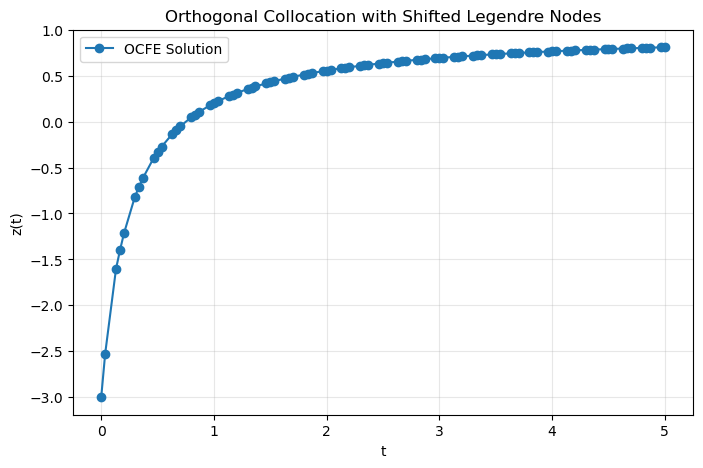

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(T, Z, 'o-', label='OCFE Solution')
plt.xlabel("t")
plt.ylabel("z(t)")
plt.title("Orthogonal Collocation with Shifted Legendre Nodes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()